# Welcome to **Hyperalignment** class!

> by Jiwoong Park and Sooahn Lee 




  Today, we are going to practice **Hyperalignment** examples using this Google Colab Notebook. **Colaboratory is free Jupyter notebook environment that runs entirely in the cloud.**  *You don't have to worry about your computing environments.* All of the software requirements and powerful computing resources are ready to go. Let's start!

 **Learning Objectives:**


*   Understand what **Hyperalignment** is and its mathematical background.
*   Using **Hyperalignment**, achieve better performance for Between-subject classification(BSC) in fMRI datasets.

**Example  datasets:**

*   Example 1: Synthetic data
*   Example 2: Visual object recognition (Haxby, 2001)
*   Example 3: Narrative comprehension (Uri Hasson, 2016)


**Package Dependencies**

*   **Numpy**   *for numerical computation*
*   **Matplotlib**   *for visualization*
*   **Scikit-learn**   *for machine-learning(SVM, tSNE)*

    *for the clarity, I've tried to use most basic packages and functions. Of course you can use fancy softwares like **pyMVPA** or **Hypertools** if you want. But it is highly recommanded to understand low-level implementation first.*







In [ ]:
# Let's define functions and load the data.
# Note: procrusted() and HyperAlign() function was adapted from python package HyperTools. 
# Source: https://github.com/ContextLab/hypertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

def procrustes(source, target):
    def fit(source, target):
        datas = (source, target)

        ##-------------- STEP 1: Normalize ---------------##
        ssqs = [np.sum(d**2, axis=0) for d in datas]
        norms = [ np.sqrt(np.sum(ssq)) for ssq in ssqs ]
        normed = [ data/norm for (data, norm) in zip(datas, norms) ]
        source, target = normed
        
        ##------ STEP 2: Calculate optimal rotation ------##
        U, s, Vh = np.linalg.svd(np.dot(target.T, source),
                                 full_matrices=False)
        T = np.dot(Vh.T, U.T)

        ##---------------- STEP 3: Scaling ---------------##
        ss = sum(s)
        scale = ss * norms[1] / norms[0]
        proj = scale * T
        
        return proj

    ##------------- STEP 4: Transformation -----------##
    proj = fit(source, target)
    return np.dot(source, proj)


def HyperAlign(data):

    ##----------- STEP 1: MAKE TEMPLATE -----------##
    # make preliminary template from subject 1 and adjust it
    template = np.copy(data[0])
    for x in range(1, len(data)):
        next = procrustes(data[x], template/(x+1))
        template += next
    template /= len(data)

    ##-------- STEP 2: NEW COMMON TEMPLATE --------##
    # align each subj to the template from STEP 1
    new_template = np.zeros(template.shape)
    for x in range(0, len(data)):
        next = procrustes(data[x], template)
        new_template += next
    new_template /= len(data)

    ##---- STEP 3: HYPER-ALIGN TO NEW TEMPLATE ----##
    # align each subj to the Final template from STEP 2
    aligned = [np.zeros(new_template.shape)] * len(data)
    for x in range(0, len(data)):
        next = procrustes(data[x], new_template)
        aligned[x] = next

    # data > Template > aligned data
    return aligned



# Example 1: Synthetic data

 First, we're going to take a look the most simple cases. Let's assume that there are only **two voxels** and **four conditions** for each subject. Then the form(shape) of data matrix would be (4, 2). *Rows mean the number of data points(conditions) and Columns mean the number of features(voxels).* 


In [ ]:
# Generate Example 1 data using Random rotation matrix
Example1_data = []
for i in range(30): # 30 denotes the number of subjects
    tmp = []
    a = np.array([0, 1]) * np.abs(np.random.normal())
    theta = 0
    for j in range(4):
        theta = theta + np.pi/2 + 0.3*np.pi*np.random.normal()
        RM = np.array([[np.cos(theta), -np.sin(theta)],
                       [np.sin(theta),  np.cos(theta)]])

        b = np.dot(RM, a)
        tmp.append(b)
    Example1_data.append(np.array(tmp))
  

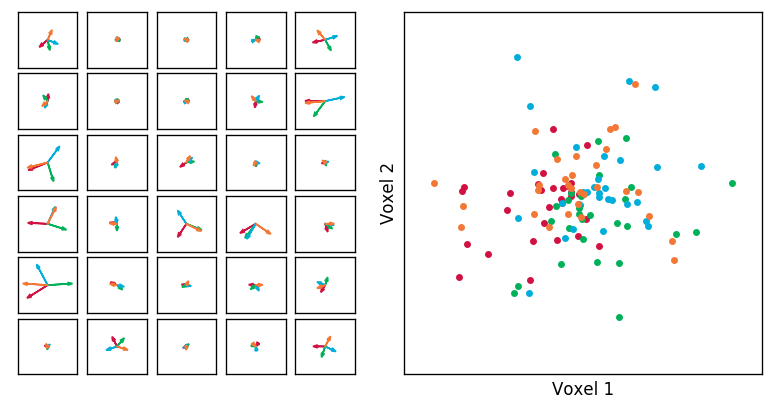

In [ ]:
# Plotting Example 1 data
color = ['#d11141', '#00b159', '#00aedb','#f37735'] # colors for four conditions
plt.figure(figsize=(8,4), dpi=120)
gs = gridspec.GridSpec(6, 7, height_ratios=[1,1,1,1,1,1],
                             width_ratios =[1,1,1,1,1,0.5,6], wspace=0.1, hspace=0.1)
count = 0
limmin = np.min(np.array(Example1_data))*1.2
limmax = np.max(np.array(Example1_data))*1.2
for i in range(6):
  for ii in range(5):
    plt.subplot(gs[i,ii])
    for j in range(4):
      plt.arrow(0,0,Example1_data[count][j,0],Example1_data[count][j,1], 
                color=color[j], width=limmax*0.005, head_width=limmax*0.1,
                length_includes_head=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(limmin,limmax)
    plt.ylim(limmin,limmax)
    count += 1

plt.subplot(gs[:,6])
for j in range(4):
    plt.scatter(np.array(Example1_data)[:,j,0], 
                np.array(Example1_data)[:,j,1],
                s=10, c=color[j])
plt.xlabel('Voxel 1')
plt.ylabel('Voxel 2')
plt.xticks([])
plt.yticks([])
plt.xlim(limmin,limmax)
plt.ylim(limmin,limmax)
plt.show()


In [ ]:
# Hyperalignment magic!
Example1_data_align = HyperAlign(Example1_data)


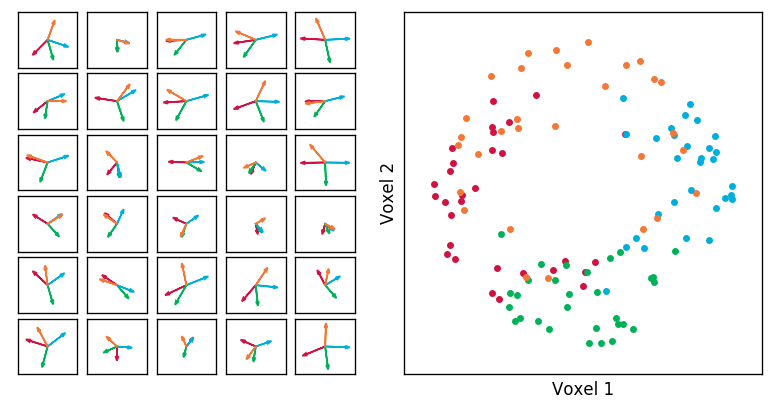

In [ ]:
# Plotting Example 1 data with Hyperalignment
color = ['#d11141', '#00b159', '#00aedb','#f37735'] # colors for four conditions
plt.figure(figsize=(8,4), dpi=120)
gs = gridspec.GridSpec(6, 7, height_ratios=[1,1,1,1,1,1],
                             width_ratios =[1,1,1,1,1,0.5,6], wspace=0.1, hspace=0.1)
count = 0
limmin = np.min(np.array(Example1_data_align))*1.2
limmax = np.max(np.array(Example1_data_align))*1.2
for i in range(6):
  for ii in range(5):
    plt.subplot(gs[i,ii])
    for j in range(4):
      plt.arrow(0,0,Example1_data_align[count][j,0],Example1_data_align[count][j,1], 
                color=color[j], width=limmax*0.005, head_width=limmax*0.1,
                length_includes_head=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(limmin,limmax)
    plt.ylim(limmin,limmax)
    count += 1

plt.subplot(gs[:,6])
for j in range(4):
    plt.scatter(np.array(Example1_data_align)[:,j,0], 
                np.array(Example1_data_align)[:,j,1],
                s=10, c=color[j])
plt.xlabel('Voxel 1')
plt.ylabel('Voxel 2')
plt.xticks([])
plt.yticks([])
plt.xlim(limmin,limmax)
plt.ylim(limmin,limmax)
plt.show()

# Example 2: Visual object recognition (Haxby, 2001)

 Now we have real fMRI data from [This study](https://science.sciencemag.org/content/293/5539/2425). This block-design fMRI dataset is open to the public. You can download this data including preprocessed fMRI data, ventral-temporal cortex ROI mask and Stimuli onset information from [here](http://data.pymvpa.org/datasets/haxby2001/) or OpenfMRI. However, I had converted both fMRI data and Stimuli information to simple **TSV text** files. In this example, we're going to use it. But remember, **it is real fMRI data!**


In [ ]:
# Let's load the data

# fMRI data from 4 subjects (Haxby, 2001)
# Dimensions of each subject data would be (756, 675).
# 756 : the number of Timepoints (108TRs for each visual object).
# 675 : the number of Ventral-Temporal cortex Voxels.
Example2_data = [np.loadtxt('./Example2/subj0_data.txt'),
                 np.loadtxt('./Example2/subj1_data.txt'),
                 np.loadtxt('./Example2/subj2_data.txt'),
                 np.loadtxt('./Example2/subj3_data.txt')]

# 7 Visual object Stimuli (Haxby, 2001)
# it contains 756 rows (108TRs for each visual object).
# Each integer mean following objects 
# 0 : 'bottle'
# 1 : 'cat'
# 2 : 'chair'
# 3 : 'face'
# 4 : 'house'
# 5 : 'scissors'
# 6 : 'shoe'

Example2_label = np.loadtxt('./Example2/visual_object.txt')


Subject 1 mean test accuracy: 0.819
Subject 2 mean test accuracy: 0.700
Subject 3 mean test accuracy: 0.770
Subject 4 mean test accuracy: 0.818


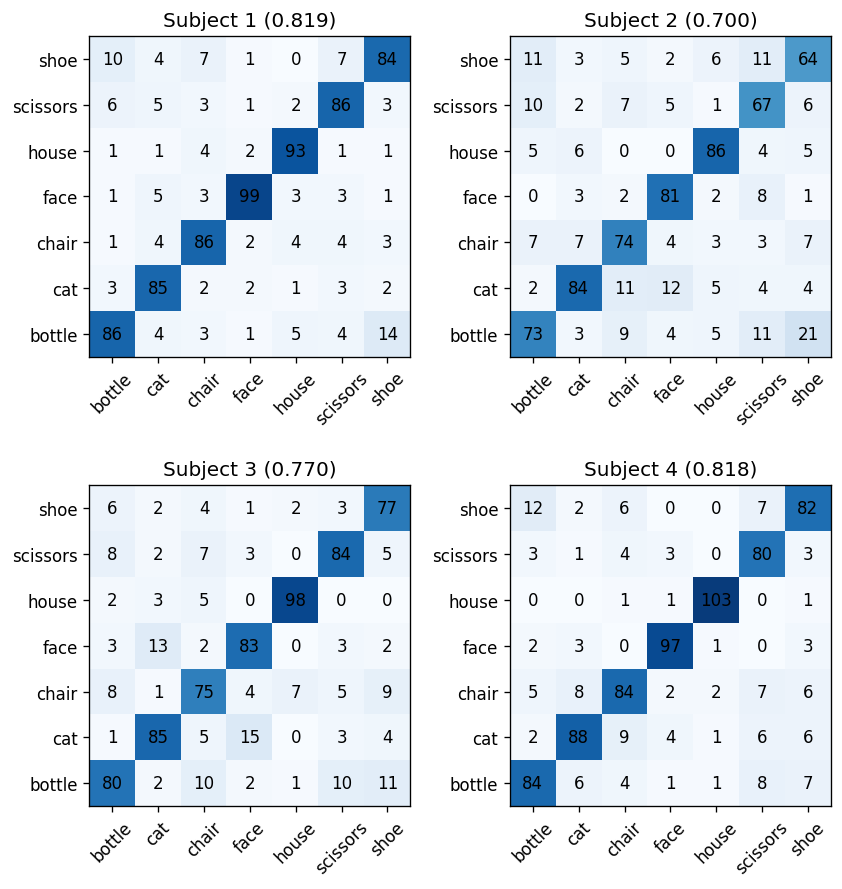

In [ ]:
# Whitin-subject Classification
# Linear SVM and 5-Fold cross validation are used.

Labels = ['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'shoe']
kfold = KFold(n_splits=5, shuffle=True)
plt.figure(figsize=(8,8.5), dpi=120)
for i, data in enumerate(Example2_data): # for each subject
  pred, test= [], []
  accuracy = 0
  for train_idx, test_idx in kfold.split(data): # for each fold
      X_train, X_test = data[train_idx,:], data[test_idx,:]
      y_train, y_test = Example2_label[train_idx], Example2_label[test_idx]

      # build within-subject classification SVM
      linear_SVM = SVC(kernel='linear')
      linear_SVM.fit(X_train, y_train)
      y_pred = linear_SVM.predict(X_test)
      pred += y_pred.tolist()
      test += y_test.tolist()
      accuracy += linear_SVM.score(X_test, y_test)

  # print mean test accuracy of within-subject model
  print('Subject '+str(i+1)+' mean test accuracy: {:0.3f}'.format(accuracy/5))

  # Visualize confusion matrix
  # X-axis means Predicted labels
  # Y-axis means Actual labels
  plt.subplot(2,2,i+1)
  plt.imshow(confusion_matrix(pred, test), cmap='Blues')
  plt.clim(0,108)
  plt.title('Subject '+str(i+1)+' ({:0.3f})'.format(accuracy/5))
  plt.xticks(np.arange(len(Labels)), Labels, rotation=45)
  plt.yticks(np.arange(len(Labels)), Labels)
  plt.ylim(-0.5,len(Labels)-0.5)

  for j in range(len(Labels)):
      for k in range(len(Labels)):
          c = confusion_matrix(pred, test)[k, j]
          plt.text(j, k, str(c), va='center', ha='center')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


BSC mean test accuracy: 0.621


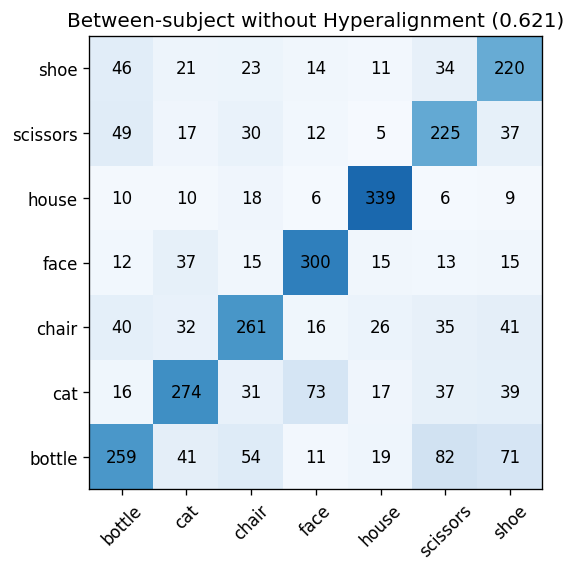

In [ ]:
# Between-subject Classification without Hyperalignment
# We're going to make single classification model.
# Linear SVM and 5-Fold cross validation are used.

# concatenate data (without hyperalignment)
concat_data = np.vstack((Example2_data[0],
                         Example2_data[1],
                         Example2_data[2],
                         Example2_data[3]))
concat_label = np.tile(Example2_label, 4)

kfold = KFold(n_splits=5, shuffle=True)
pred, test= [], []
accuracy = 0
for train_idx, test_idx in kfold.split(concat_data): # for each fold
    X_train, X_test = concat_data[train_idx,:], concat_data[test_idx,:]
    y_train, y_test = concat_label[train_idx], concat_label[test_idx]

    # build single classification model
    linear_SVM = SVC(kernel='linear')
    linear_SVM.fit(X_train, y_train)
    y_pred = linear_SVM.predict(X_test)
    pred += y_pred.tolist()
    test += y_test.tolist()
    accuracy += linear_SVM.score(X_test, y_test)

# print mean test accuracy of Between-subject model
print('BSC mean test accuracy: {:0.3f}'.format(accuracy/5))

# Visualize confusion matrix
# X-axis means Predicted labels
# Y-axis means Actual labels
plt.figure(figsize=(5,5), dpi=120)
plt.imshow(confusion_matrix(pred, test), cmap='Blues')
plt.clim(0,108*4)
plt.title('Between-subject without Hyperalignment ({:0.3f})'.format(accuracy/5))
plt.xticks(np.arange(len(Labels)), Labels, rotation=45)
plt.yticks(np.arange(len(Labels)), Labels)
plt.ylim(-0.5,len(Labels)-0.5)

for j in range(len(Labels)):
    for k in range(len(Labels)):
        c = confusion_matrix(pred, test)[k, j]
        plt.text(j, k, str(c), va='center', ha='center')

plt.show()

In [ ]:
# Hyperalignment magic!
Example2_data_align = HyperAlign(Example2_data)


BSC mean test accuracy: 0.849


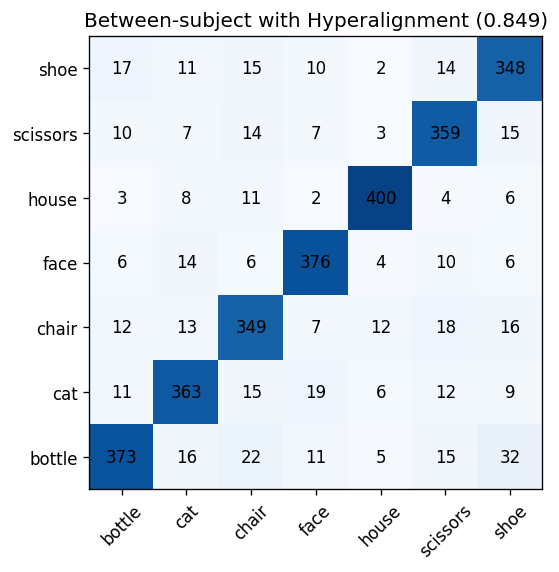

In [ ]:
# Between-subject Classification with Hyperalignment
# We're going to make single classification model.
# Linear SVM and 5-Fold cross validation are used.

# concatenate data (with hyperalignment)
concat_data = np.vstack((Example2_data_align[0],
                         Example2_data_align[1],
                         Example2_data_align[2],
                         Example2_data_align[3]))
concat_label = np.tile(Example2_label, 4)

kfold = KFold(n_splits=5, shuffle=True)
pred, test= [], []
accuracy = 0
for train_idx, test_idx in kfold.split(concat_data): # for each fold
    X_train, X_test = concat_data[train_idx,:], concat_data[test_idx,:]
    y_train, y_test = concat_label[train_idx], concat_label[test_idx]

    # build single classification model
    linear_SVM = SVC(kernel='linear')
    linear_SVM.fit(X_train, y_train)
    y_pred = linear_SVM.predict(X_test)
    pred += y_pred.tolist()
    test += y_test.tolist()
    accuracy += linear_SVM.score(X_test, y_test)

# print mean test accuracy of Between-subject model
print('BSC mean test accuracy: {:0.3f}'.format(accuracy/5))

# Visualize confusion matrix
# X-axis means Predicted labels
# Y-axis means Actual labels
plt.figure(figsize=(5,5), dpi=120)
plt.imshow(confusion_matrix(pred, test), cmap='Blues')
plt.clim(0,108*4)
plt.title('Between-subject with Hyperalignment ({:0.3f})'.format(accuracy/5))
plt.xticks(np.arange(len(Labels)), Labels, rotation=45)
plt.yticks(np.arange(len(Labels)), Labels)
plt.ylim(-0.5,len(Labels)-0.5)

for j in range(len(Labels)):
    for k in range(len(Labels)):
        c = confusion_matrix(pred, test)[k, j]
        plt.text(j, k, str(c), va='center', ha='center')

plt.show()

# Example 3: Narrative comprehension (Uri Hasson, 2016)
Now, we'are going to *hyper-align* continuous fMRI data not block design. The original data is open to public in [Princeton Neuroscience DB](https://dataspace.princeton.edu/jspui/handle/88435/dsp015d86p269k). However, Jeremy R. Manning processed this data using his functional-connectivity based method(HTFA, research article is [here](https://www.biorxiv.org/content/10.1101/106690v1)). Then we will use that processed data. Remember, in this case, feature dimensionality does not mean voxel space, it denotes functional-connectivity nodes in Default Mode Network.


In [ ]:
# Note: This is adapted from https://github.com/ContextLab/hypertools tutorial

# Let's load the data
# The shape of each subject data would be (120,100).
# #Rows(120) means its time-point during Narrative comprehension(120TRs*1500ms = 180s = 3min)
# #Cols(100) indicates that the number of connectivity nodes in DMN.
# for this tutorial, I trimmed its time-point. original data contains 300 TP (300TRs*1500ms = 7.5min)
# Total number of subject is 36. 
# The first 18 subjects are used for modeling and Remainings(N=18) for its replication.
# Now we're going to hyper-align all subject and see similarity between two group.

Example3_data = [np.loadtxt('./Example3/subj{:d}_data.txt'.format(i)) for i in range(36)]


In [ ]:
# t-SNE is a efficient tool to visualize High-dimensional data.
# The dimensionality of original data (DMN Nodes: 100) is too high to visualize
# then t-SNE is going to reduce its dimension to 2(for 2D plot).
# It requires more resources then other dimensionality reduction methods.

model = TSNE()
Example3_tsne = model.fit_transform(np.array(Example3_data).reshape(36*120,100))
Example3_tsne = Example3_tsne.reshape(36,120,2)


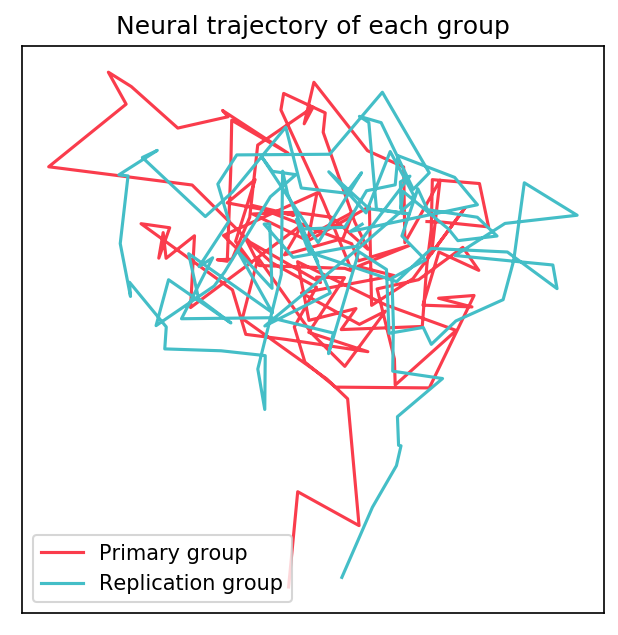

In [ ]:
plt.figure(figsize=(5,5), dpi=150)
plt.plot(np.mean(Example3_tsne[:18], axis=0)[:,0],
         np.mean(Example3_tsne[:18], axis=0)[:,1],
         '-', c='#fa3c4c', label='Primary group')
plt.plot(np.mean(Example3_tsne[18:], axis=0)[:,0],
         np.mean(Example3_tsne[18:], axis=0)[:,1],
         '-', c='#44bec7', label='Replication group')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Neural trajectory of each group')
plt.show()


In [ ]:
# Hyperalignment magic!
Example3_data_align = HyperAlign(Example3_data)


In [ ]:
# ...and t-SNE again.. 
model = TSNE()
Example3_align_tsne = model.fit_transform(np.array(Example3_data_align).reshape(36*120,100))
Example3_align_tsne = Example3_align_tsne.reshape(36,120,2)


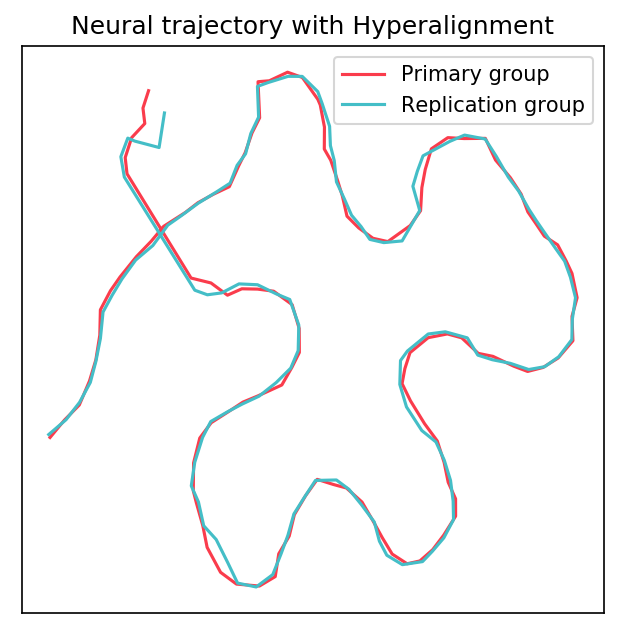

In [ ]:
plt.figure(figsize=(5,5), dpi=150)
plt.plot(np.mean(Example3_align_tsne[:18], axis=0)[:,0],
         np.mean(Example3_align_tsne[:18], axis=0)[:,1],
         '-', c='#fa3c4c', label='Primary group')
plt.plot(np.mean(Example3_align_tsne[18:], axis=0)[:,0],
         np.mean(Example3_align_tsne[18:], axis=0)[:,1],
         '-', c='#44bec7', label='Replication group')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Neural trajectory with Hyperalignment')
plt.show()

In [ ]:
import hypertools as hyp

In [ ]:
!pip install hypertools

In [ ]:
hyp.plot(np.mean(Example3_data[:18], axis=0))

In [ ]:
hyp.align(Example3_data)